## Notebook for Predicting Daily Meter Revenue

This notebook was made separate from the reporting notebook in order to multitask. Some overlap in beginning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as st
import numpy as np
import sklearn as sk
import datetime
from math import radians, sin, cos, pi, asin, atan2
import datetime
import copy
% matplotlib inline

In [2]:
try: 

    df_meters = pd.read_csv('parking_meters_sd.csv', delimiter= '\t', encoding = 'ISO-8859-1')
    df_trans = pd.read_csv('meter_transactions_2017.csv', delimiter= '\t', encoding = 'ISO-8859-1')
    meter_dict = pd.read_csv('parking_meters_sd_dict.csv', delimiter= '\t', encoding = 'ISO-8859-1')
    trans_dict = pd.read_csv('meter_transactions_2017_dict.csv', delimiter= '\t', encoding = 'ISO-8859-1')

    print('Loaded dataframes from file')
    
except:
    urls = ['http://seshat.datasd.org/parking_meters/treas_parking_meters_loc_datasd.csv', 'http://seshat.datasd.org/parking_meters/meters_locations_dictionary_datasd.csv', 
            'http://seshat.datasd.org/parking_meters/treas_parking_payments_2017_datasd.csv', 'http://seshat.datasd.org/parking_meters/meters_transactions_dictionary_datasd.csv']
    
    df_titles = ['parking_meters_sd', 'parking_meters_sd_dict', 'meter_transactions_2017', 'meter_transactions_2017_dict']
    for i in range(len(urls)):
        df = pd.read_csv(urls[i])
        fname = df_titles[i] + '.csv'
        print('Loading ' + fname + ' dataframe from url. Saving to csv...')
        df.to_csv(fname, sep = '\t', index=False)
        
        print('Saving...')
    df_meters = pd.read_csv('parking_meters_sd.csv', delimiter= '\t', encoding = 'ISO-8859-1')
    df_trans = pd.read_csv('meter_transactions_2017.csv', delimiter= '\t', encoding = 'ISO-8859-1')
    meter_dict = pd.read_csv('parking_meters_sd_dict.csv', delimiter= '\t', encoding = 'ISO-8859-1')
    trans_dict = pd.read_csv('meter_transactions_2017_dict.csv', delimiter= '\t', encoding = 'ISO-8859-1')
    print('Done')

Loaded dataframes from file


In [3]:
df_trans['trans_start'] = pd.to_datetime(df_trans['trans_start'])
df_trans['meter_expire'] = pd.to_datetime(df_trans['meter_expire'])

In [4]:
#df_trans['month'] = df_trans['trans_start'].map(lambda x: x.month)
df = df_trans[df_trans['trans_start'].dt.month == 7]

In [5]:
# Ignore rows outside paid parking window, as per instructions
df = df[(df['trans_start'] != df['meter_expire'])]
df = df[df['trans_start'].dt.hour<20]

Part 1: Generate file with pole_id, sub-area, year, month, day, time, fraction of time paid per 5 minute interval, transactions iniatiated, and transactions ended.

In [6]:
df_meters_sub = df_meters[['zone','area','sub_area','pole','longitude','latitude']]
df = df.merge(df_meters_sub, left_on='pole_id', right_on='pole')

In [7]:
df['year'] = df['trans_start'].dt.year
df['month'] = df['trans_start'].dt.month
df['day'] = df['trans_start'].dt.day

In [9]:
# Cleanup for ML. No null values. Remove year, month, and meter_type as they are completely homogeneous
for i in df.columns:
    if df[i].isnull().values.all():
        print(i + ' is empty')
    elif df[i].isnull().values.any():
        print(i + ' has some NaN values')
    else:
        pass
    print(i + ' has ' + str(len(df[i].unique())) + ' unique value(s)')

uuid has 860396 unique value(s)
meter_type has 1 unique value(s)
pole_id has 4640 unique value(s)
trans_amt has 132 unique value(s)
pay_method has 3 unique value(s)
trans_start has 579538 unique value(s)
meter_expire has 494148 unique value(s)
zone has 4 unique value(s)
area has 19 unique value(s)
sub_area has 586 unique value(s)
pole has 4640 unique value(s)
longitude has 3546 unique value(s)
latitude has 3749 unique value(s)
year has 1 unique value(s)
month has 1 unique value(s)
day has 30 unique value(s)


In [10]:
df.drop(['month', 'year', 'meter_type'], axis = 1, inplace=True)

Instead of going by time intervals, I prefer encoding time in sin/cos components. This allows ML algorithms to potentially include cyclicality

In [11]:
def time_columns(df, col):
    start_time = min(df[col])
    seconds_in_day = 24*60*60
    dt_seconds = df[col].apply(lambda x: ( (x.hour*3600) + (x.minute*60) + x.second) )
    df['Time_sin'] = np.sin(2*np.pi*dt_seconds/seconds_in_day)
    df['Time_cos'] = np.cos(2*np.pi*dt_seconds/seconds_in_day)
    print('Added sin/cos daily time columns')

time_columns(df,'trans_start')

Confirm that start time is within bounds of data set 2017-07-01 06:01:31
-----
Added sin/cos daily time columns


Drop uuid (no ML data), meter_expire (auto-encodes for payment), pole and pole_id (semi-redundant given other location data, ideally would keep if I had the computational power for more one-hot encoded rows), and trans_start (time encoded cyclically and still have day). Note that day does not need to be encoded the same way since we're only examining one month

In [12]:
df.drop(['uuid','meter_expire','pole','pole_id','trans_start'], axis = 1, inplace=True)

One-hot encode zone, area, and pay_method. Had originally did same for sub_area, but chose to drop it as the column count became a bit much

In [13]:
df = pd.get_dummies(df, columns = ['zone'])
df = pd.get_dummies(df, columns = ['area'])
#df = pd.get_dummies(df, columns = ['sub_area'])
df.drop(['sub_area'], axis = 1, inplace=True)

df = pd.get_dummies(df, columns = ['pay_method'])

In [1]:
df

NameError: name 'df' is not defined

In [16]:
df.columns

Index(['trans_amt', 'longitude', 'latitude', 'day', 'Time_sin', 'Time_cos',
       'zone_City', 'zone_Downtown', 'zone_Mid-City', 'zone_Uptown',
       'area_Bankers Hill', 'area_Barrio Logan', 'area_College',
       'area_Core - Columbia', 'area_Cortez Hill', 'area_East Village',
       'area_Five Points', 'area_Gaslamp', 'area_Golden Hill',
       'area_Hillcrest', 'area_Little Italy', 'area_Marina', 'area_Midtown',
       'area_Mission Beach', 'area_Mission Hills', 'area_North Park',
       'area_Point Loma', 'area_Talmadge', 'area_University Heights',
       'pay_method_CASH', 'pay_method_CREDIT CARD', 'pay_method_SMART CARD'],
      dtype='object')

In [17]:
target = df['trans_amt']
data = df.drop(['trans_amt'], axis = 1)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [19]:
# Get indices ahead of train_test_split
indices = np.arange(data.shape[0])

Scale data - note that for ML, I'm cheating here. I should technically first apply this to the training_data, then apply the same function to the test_data, but again, time constraints.  

In [20]:
scaler = StandardScaler()
scaler.fit(data)
data_std = scaler.transform(data)

In [21]:
# Due to the large data set, and insufficient computational power on my part, I need to break the data set up a bit

# First I want to retain a portion of data that never factors into training and cross-validation. Let's pick 10% of the data for that
data_cv, data_test, target_cv, target_test, id_cv, id_test = train_test_split(data_std, target, indices, test_size=0.1, random_state=11)

# Next, I want to work with more manageable data sets for model building. For building I'll use 30% of the remaining data.
data_small, data_test_big, target_small, target_test_big, id_small, id_big = train_test_split(data_cv, target_cv, id_cv, test_size=0.3, random_state=11)

As for model choice, I decided to check out what Random Forest comes up with. It turns out the transaction prediction is not excellent, but it work well in aggregate over the days. Unfortunately, this is the part where time became a major issue, with even a small Random Forest taking 20 minutes. I could lower the fraction of data used to build the model faster, but I had issues with the aggregated results looking a bit too sparse when accounting for each day.

My next step is, because Random Forest did pretty well in the aggregate, a Gradient Boosted Tree should do even better if properly tuned. The grid search for that, however, will take quite a bit more time than I can reasonably provide.

In [33]:
rf_reg = RandomForestRegressor(100, oob_score=True, verbose=True)
rf_reg.fit(data_small, target_small)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 18.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=None, verbose=True,
           warm_start=False)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.1s finished


MSE: 3535.6511144
R2: 0.46171716265


(0, 1000)

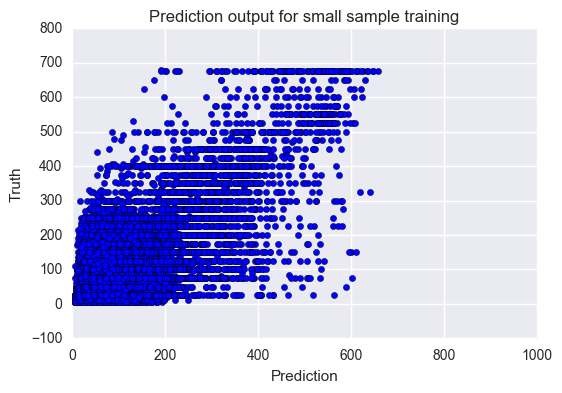

In [34]:
preds = rf_reg.predict(data_test)
print('MSE: ' + str(mean_squared_error(preds, target_test)))
print('R2: ' + str(r2_score(preds, target_test)))
plt.scatter(preds, target_test)
plt.title('Prediction output for small sample training')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.xlim([0,1000])

Assemble the aggregated results for the sample

In [35]:
results = df[['day','trans_amt']].iloc[id_test]
results['preds'] = preds

In [36]:
results_day = results.groupby('day').agg(np.sum)
percent_dif = results_day.apply(lambda x: 100*abs(float(x['trans_amt'])-x['preds'])/x['trans_amt'], axis=1)

In [41]:
results_day['pct_dif'] = percent_dif
results_day['raw_dif'] = results_day['preds'] - results_day['trans_amt']

For the untested sample, we see percent differences that are fairly close when aggregated by day, with most percentages being less than 1.5%. Only ones larger tend to be ones with small in-sample sizes, like ones on holidays.

In [42]:
results_day

,trans_amt,preds,pct_dif,raw_dif
day,,,,
1,349051,343621.930000,1.555380,-5429.070000
3,362547,358873.960000,1.013121,-3673.040000
4,320,277.500000,13.281250,-42.500000
5,360924,360788.740000,0.037476,-135.260000
6,382048,384409.090000,0.618009,2361.090000
7,392178,393690.270000,0.385608,1512.270000
8,357496,351680.713333,1.626672,-5815.286667
10,355499,353463.316667,0.572627,-2035.683333
11,389796,386172.263333,0.929650,-3623.736667


In [45]:
results_day.to_csv('revenue_predictions_SD_July_2017_sampled.csv', sep = '\t')

Now, we can aggregate them for all data points to get total cash flows, but it's important to keep in mind that this will use points that were used in training, so the predictions are expected to be more accurate (but not for the right reasons).

In [39]:
data_all, data_na, target_all, target_na, id_all, id_na = train_test_split(data_std, target, indices, test_size=0, random_state=11)
all_preds = rf_reg.predict(data_all)
all_results = df[['day','trans_amt']].iloc[id_all]
all_results['preds'] = all_preds
all_results_day = all_results.groupby('day').agg(np.sum)
all_results_day['raw_dif'] = all_results_day['preds'] - all_results_day['trans_amt']
all_percent_dif = all_results_day.apply(lambda x: 100*abs(float(x['raw_dif']))/x['trans_amt'], axis=1)
all_results_day['pct_dif'] = all_percent_dif

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished


In [40]:
all_results_day

,trans_amt,preds,raw_dif,pct_dif
day,,,,
1,3525629,3.502501e+06,-23127.666667,0.655987
2,185,2.217000e+02,36.700000,19.837838
3,3587766,3.589017e+06,1250.510000,0.034855
4,7500,7.443850e+03,-56.150000,0.748667
5,3642764,3.635410e+06,-7353.940000,0.201878
6,3853560,3.844245e+06,-9314.753333,0.241718
7,3807751,3.808403e+06,651.610000,0.017113
8,3529107,3.469198e+06,-59909.238333,1.697575
10,3462498,3.456183e+06,-6315.156667,0.182387


In [46]:
all_results_day.to_csv('revenue_predictions_SD_July_2017_complete.csv', sep = '\t')

When we aggregate for all days, my predictions generally come out to less than a 1% difference on any given day. Of course, we part of this is the fact that 1% could be >400 dollars, in this set. The largest error missed the daily mark by ~800 dollars.

Interestingly, these predictions tend to underestimate the daily totals generally, meaning certain days earned more in reality. I suspect an aspect of this is because our data set does not keep track of events. Weather could also impact if you were to analyze a year's worth of data or more (weather was quite consistent and nice during this time, according to some quick research). 

Note that we still get these fairly accurate predictions overall despite the model achieving fairly unimpressive R^2 values and mean-squared errors. Outlier detection may tighten this up a bit, as I did not thoroughly investigate outliers in favor of capturing entire data set.

Unfortunately my current computational power is rather limited, but with more time I would expect moderate-to-substantial improvements.

Feature selection via Lasso was also attempted to speed up grid searching for boosted trees and support vector regressor

In [22]:
lasso = LassoCV(n_alphas=1000)
lasso.fit(data_small, target_small)
sfm = SelectFromModel(lasso, threshold=0.05)
sfm.fit(data_small, target_small)
n_features = sfm.transform(data_small).shape[1]
print(n_features)

25


In [ ]:
gbt_params = {'learning_rate': [0.2, 0.3,0.5], 
              'max_depth':[5,6,7,8]}

gbt_gs = GridSearchCV(GradientBoostingRegressor(n_estimators=1000, random_state=11), param_grid = gbt_params, n_jobs=3, cv=3, verbose=10)
gbt_gs.fit(sfm.transform(data_small),target_small)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [ ]:
gbt_reg = SVR(verbose=True)
gbt_reg.fit(data_small, target_small)

In [ ]:
#svr_params = {'C': [0.1, 0.5, 1.0, 2, 10, 100], 
#              'epsilon':[0.2, 0.1, 0.01, 0],
#              'gamma': ['auto', 0.01, 0.1],
#             'kernel': ['rbf', 'sigmoid']}
#svr_test = SVR(C = 1.5, epsilon = 0.1, kernel ='rbf', gamma = 0.2)
#svr_test.fit(data_small,target_small)
#preds = svr_test.predict(data_test_small)

Just to see, I did a basic linear regression. The fit is quite a bit worse than the random forest

In [28]:
LR = LinearRegression()
LR.fit(data_small, target_small)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

MSE: 4031.59198047
R2: 0.225327889385


(0, 1000)

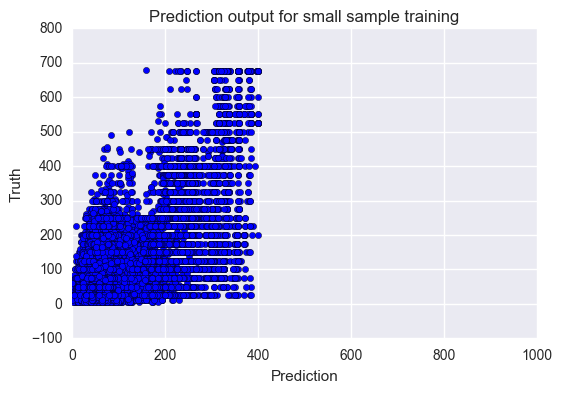

In [45]:
preds = LR.predict(data_test)
print('MSE: ' + str(mean_squared_error(preds, target_test)))
print('R2: ' + str(r2_score(preds, target_test)))
plt.scatter(preds, target_test)
plt.title('Prediction output for small sample training')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.xlim([0,1000])